In [43]:
import numpy as np
import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings(action='ignore')

import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle
import gzip

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 모든 컬럼이 표시되도록 max_columns 의 수를 지정합니다.
pd.options.display.max_columns = 39

In [15]:
shk = np.load("/project/guri/3d_array.npy")
shk.sum()

771616.0

In [16]:
gyk = np.load("3d_array_k.npy")
gyk.sum()

742746.0

In [27]:
for i in range(15):
    print(shk[i,:,:].sum(),'         :         
          ', gyk[i,:,:].sum())

77.0          :          73.0
160.0          :          154.0
122.0          :          117.0
104.0          :          99.0
78.0          :          77.0
112.0          :          112.0
224.0          :          199.0
92.0          :          92.0
118.0          :          116.0
83.0          :          83.0
65.0          :          62.0
119.0          :          118.0
138.0          :          136.0
107.0          :          94.0
113.0          :          111.0


# DATA 로드 및 EDA

In [31]:
# load and uncompress.
with gzip.open('3d_array_k.pickle','rb') as f:
    arr = pickle.load(f)

In [32]:
label = np.load("/project/guri/3d_array_label.npy")

label.shape

(7799, 1)

In [33]:
label_2d = np.load("/project/guri/3d_array_label_2d.npy")

In [34]:
arr.sum()

742746.0

In [35]:
arr.sum()/(7799*690*10)

0.013802326942696109

In [36]:
arr1 = arr.reshape(arr.shape[0], arr.shape[2], arr.shape[1])
arr1.shape

(7799, 10, 690)

In [37]:
arr1[0,:,:].sum()

73.0

# 데이터 나누기

In [38]:
arr1.shape[0] * 0.7

5459.299999999999

In [39]:
# 5500을 기준으로 split
X_train = arr1[:5500,:,:]
y_train = label[:5500,:]
# y_train = label_2d[:5500,:]


X_test = arr1[5500:,:,:]
y_test = label[5500:,:]
# y_test = label_2d[5500:,:]



X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5500, 10, 690), (5500, 1), (2299, 10, 690), (2299, 1))

In [40]:
label.sum()/7799

0.6122579817925375

# LSTM

In [41]:
from keras.regularizers import l2

In [44]:
lstm = Sequential()
lstm.add(LSTM(units=12, activation='tanh', input_shape=(arr1.shape[1], arr1.shape[2]),return_sequences=True,
         bias_regularizer=l2(0.001), kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001)))
lstm.add(LSTM(units=12, activation='tanh', input_shape=(12, arr1.shape[2]),
              bias_regularizer=l2(0.001), kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001)))
lstm.add(Dense(units=1, activation='sigmoid'))
print(lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 12)            33744     
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1200      
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 34,957
Trainable params: 34,957
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
from keras.callbacks import EarlyStopping

lstm.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['acc']) #loss='categorical_crossentropy'
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = lstm.fit(X_train, y_train, validation_split=0.25, batch_size=256, epochs=500,  callbacks=[early_stop])

Epoch 1/500
17/17 [==============================] - 12s 56ms/step - loss: 0.7903 - acc: 0.6177 - val_loss: 0.7730 - val_acc: 0.5782
Epoch 2/500
17/17 [==============================] - 0s 13ms/step - loss: 0.6734 - acc: 0.6937 - val_loss: 0.7728 - val_acc: 0.5782
Epoch 3/500
17/17 [==============================] - 0s 13ms/step - loss: 0.6319 - acc: 0.7020 - val_loss: 0.7117 - val_acc: 0.6356
Epoch 4/500
17/17 [==============================] - 0s 14ms/step - loss: 0.5870 - acc: 0.7495 - val_loss: 0.7027 - val_acc: 0.6662
Epoch 5/500
17/17 [==============================] - 0s 14ms/step - loss: 0.5742 - acc: 0.7642 - val_loss: 0.7494 - val_acc: 0.6596
Epoch 6/500
17/17 [==============================] - 0s 13ms/step - loss: 0.5605 - acc: 0.7694 - val_loss: 0.6514 - val_acc: 0.7069
Epoch 7/500
17/17 [==============================] - 0s 12ms/step - loss: 0.5391 - acc: 0.7832 - val_loss: 0.7200 - val_acc: 0.6815
Epoch 8/500
17/17 [==============================] - 0s 12ms/step - loss: 0

Text(0.5, 1.0, 'Model acc')

Text(0, 0.5, 'acc')

Text(0.5, 0, 'Epoch')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


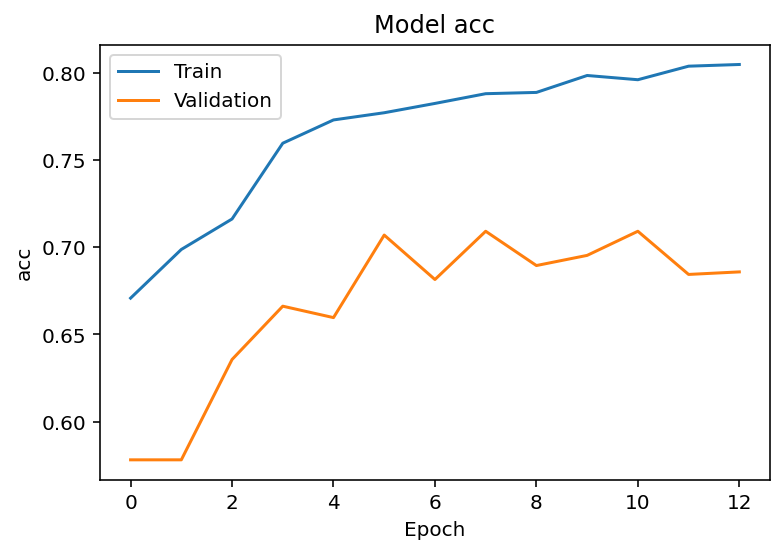

In [46]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# LSTM 2

In [47]:
arr1.shape

(7799, 10, 690)

In [48]:
lstm = Sequential()
lstm.add(LSTM(units=8, activation='sigmoid', recurrent_activation='hard_sigmoid', input_shape=(arr1.shape[1], arr1.shape[2])))
# lstm.add(LSTM(units=8, activation='sigmoid', recurrent_activation='hard_sigmoid', input_shape=(8, arr1.shape[2])))
lstm.add(Dense(units=1, activation='sigmoid'))
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 22368     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 22,377
Trainable params: 22,377
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
arr1.shape[2]

690

In [78]:
from keras.callbacks import EarlyStopping

lstm.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc']) #loss='categorical_crossentropy'
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = lstm.fit(X_train, y_train, validation_split=0.25, batch_size=2048, epochs=2000)#,  callbacks=[early_stop])

Epoch 1/2000
3/3 [==============================] - 2s 189ms/step - loss: 0.0340 - acc: 0.9953 - val_loss: 1.4194 - val_acc: 0.6778
Epoch 2/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0320 - acc: 0.9954 - val_loss: 1.4182 - val_acc: 0.6793
Epoch 3/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0350 - acc: 0.9950 - val_loss: 1.3955 - val_acc: 0.6793
Epoch 4/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0341 - acc: 0.9947 - val_loss: 1.4047 - val_acc: 0.6829
Epoch 5/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0332 - acc: 0.9948 - val_loss: 1.4425 - val_acc: 0.6691
Epoch 6/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0341 - acc: 0.9951 - val_loss: 1.4270 - val_acc: 0.6749
Epoch 7/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0364 - acc: 0.9950 - val_loss: 1.4045 - val_acc: 0.6800
Epoch 8/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0347 - 

3/3 [==============================] - 0s 34ms/step - loss: 0.0324 - acc: 0.9965 - val_loss: 1.4519 - val_acc: 0.6807
Epoch 64/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0295 - acc: 0.9961 - val_loss: 1.4343 - val_acc: 0.6771
Epoch 65/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0314 - acc: 0.9955 - val_loss: 1.4612 - val_acc: 0.6793
Epoch 66/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0295 - acc: 0.9963 - val_loss: 1.4796 - val_acc: 0.6749
Epoch 67/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0298 - acc: 0.9963 - val_loss: 1.4313 - val_acc: 0.6771
Epoch 68/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.0354 - acc: 0.9950 - val_loss: 1.4368 - val_acc: 0.6749
Epoch 69/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.0314 - acc: 0.9956 - val_loss: 1.4977 - val_acc: 0.6785
Epoch 70/2000
3/3 [==============================] - 0s 28ms/step - loss: 0.0329 - acc: 0.

Epoch 125/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0269 - acc: 0.9966 - val_loss: 1.5111 - val_acc: 0.6778
Epoch 126/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0288 - acc: 0.9962 - val_loss: 1.5141 - val_acc: 0.6778
Epoch 127/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0277 - acc: 0.9965 - val_loss: 1.5176 - val_acc: 0.6771
Epoch 128/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0290 - acc: 0.9962 - val_loss: 1.5241 - val_acc: 0.6764
Epoch 129/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0287 - acc: 0.9967 - val_loss: 1.5075 - val_acc: 0.6785
Epoch 130/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0276 - acc: 0.9965 - val_loss: 1.4979 - val_acc: 0.6793
Epoch 131/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0297 - acc: 0.9963 - val_loss: 1.5051 - val_acc: 0.6785
Epoch 132/2000
3/3 [==============================] - 0s 31ms/step - 

3/3 [==============================] - 0s 30ms/step - loss: 0.0236 - acc: 0.9970 - val_loss: 1.5314 - val_acc: 0.6829
Epoch 187/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0244 - acc: 0.9970 - val_loss: 1.5296 - val_acc: 0.6800
Epoch 188/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0268 - acc: 0.9965 - val_loss: 1.5340 - val_acc: 0.6807
Epoch 189/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0248 - acc: 0.9969 - val_loss: 1.5425 - val_acc: 0.6800
Epoch 190/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0227 - acc: 0.9971 - val_loss: 1.5442 - val_acc: 0.6785
Epoch 191/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0243 - acc: 0.9969 - val_loss: 1.5348 - val_acc: 0.6785
Epoch 192/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0254 - acc: 0.9968 - val_loss: 1.5410 - val_acc: 0.6785
Epoch 193/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0257 - 

Epoch 248/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.0229 - acc: 0.9972 - val_loss: 1.5645 - val_acc: 0.6735
Epoch 249/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0209 - acc: 0.9974 - val_loss: 1.5794 - val_acc: 0.6785
Epoch 250/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0205 - acc: 0.9977 - val_loss: 1.5843 - val_acc: 0.6785
Epoch 251/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0219 - acc: 0.9974 - val_loss: 1.5686 - val_acc: 0.6764
Epoch 252/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0193 - acc: 0.9977 - val_loss: 1.5549 - val_acc: 0.6771
Epoch 253/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0215 - acc: 0.9974 - val_loss: 1.5591 - val_acc: 0.6778
Epoch 254/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0202 - acc: 0.9976 - val_loss: 1.5774 - val_acc: 0.6764
Epoch 255/2000
3/3 [==============================] - 0s 31ms/step - 

3/3 [==============================] - 0s 30ms/step - loss: 0.0201 - acc: 0.9981 - val_loss: 1.6438 - val_acc: 0.6742
Epoch 310/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0183 - acc: 0.9982 - val_loss: 1.6124 - val_acc: 0.6756
Epoch 311/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0200 - acc: 0.9979 - val_loss: 1.6058 - val_acc: 0.6771
Epoch 312/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0185 - acc: 0.9982 - val_loss: 1.6171 - val_acc: 0.6778
Epoch 313/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0195 - acc: 0.9979 - val_loss: 1.6316 - val_acc: 0.6735
Epoch 314/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.0179 - acc: 0.9982 - val_loss: 1.6405 - val_acc: 0.6727
Epoch 315/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.0184 - acc: 0.9982 - val_loss: 1.6388 - val_acc: 0.6720
Epoch 316/2000
3/3 [==============================] - 0s 28ms/step - loss: 0.0180 - 

Epoch 371/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0167 - acc: 0.9982 - val_loss: 1.6519 - val_acc: 0.6756
Epoch 372/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0178 - acc: 0.9981 - val_loss: 1.6525 - val_acc: 0.6749
Epoch 373/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0191 - acc: 0.9978 - val_loss: 1.6490 - val_acc: 0.6749
Epoch 374/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0183 - acc: 0.9979 - val_loss: 1.6439 - val_acc: 0.6771
Epoch 375/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0180 - acc: 0.9981 - val_loss: 1.6383 - val_acc: 0.6749
Epoch 376/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0186 - acc: 0.9979 - val_loss: 1.6403 - val_acc: 0.6756
Epoch 377/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0168 - acc: 0.9982 - val_loss: 1.6497 - val_acc: 0.6756
Epoch 378/2000
3/3 [==============================] - 0s 33ms/step - 

3/3 [==============================] - 0s 37ms/step - loss: 0.0153 - acc: 0.9985 - val_loss: 1.6550 - val_acc: 0.6742
Epoch 433/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0150 - acc: 0.9985 - val_loss: 1.6649 - val_acc: 0.6778
Epoch 434/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0150 - acc: 0.9985 - val_loss: 1.6913 - val_acc: 0.6749
Epoch 435/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0177 - acc: 0.9982 - val_loss: 1.6795 - val_acc: 0.6778
Epoch 436/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0137 - acc: 0.9989 - val_loss: 1.6577 - val_acc: 0.6691
Epoch 437/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0139 - acc: 0.9988 - val_loss: 1.6532 - val_acc: 0.6647
Epoch 438/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.0165 - acc: 0.9984 - val_loss: 1.6636 - val_acc: 0.6756
Epoch 439/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0140 - 

Epoch 494/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0134 - acc: 0.9985 - val_loss: 1.6663 - val_acc: 0.6684
Epoch 495/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0147 - acc: 0.9984 - val_loss: 1.6683 - val_acc: 0.6669
Epoch 496/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0132 - acc: 0.9987 - val_loss: 1.6853 - val_acc: 0.6778
Epoch 497/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.0152 - acc: 0.9982 - val_loss: 1.6899 - val_acc: 0.6764
Epoch 498/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0143 - acc: 0.9984 - val_loss: 1.6729 - val_acc: 0.6742
Epoch 499/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0146 - acc: 0.9984 - val_loss: 1.6606 - val_acc: 0.6713
Epoch 500/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0137 - acc: 0.9985 - val_loss: 1.6570 - val_acc: 0.6720
Epoch 501/2000
3/3 [==============================] - 0s 42ms/step - 

3/3 [==============================] - 0s 31ms/step - loss: 0.0108 - acc: 0.9990 - val_loss: 1.6887 - val_acc: 0.6720
Epoch 556/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0119 - acc: 0.9988 - val_loss: 1.6890 - val_acc: 0.6720
Epoch 557/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0110 - acc: 0.9989 - val_loss: 1.6921 - val_acc: 0.6713
Epoch 558/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0128 - acc: 0.9986 - val_loss: 1.6918 - val_acc: 0.6735
Epoch 559/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0118 - acc: 0.9987 - val_loss: 1.6928 - val_acc: 0.6727
Epoch 560/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.0104 - acc: 0.9990 - val_loss: 1.6930 - val_acc: 0.6705
Epoch 561/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0115 - acc: 0.9987 - val_loss: 1.6940 - val_acc: 0.6720
Epoch 562/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0111 - 

Epoch 617/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0101 - acc: 0.9989 - val_loss: 1.7369 - val_acc: 0.6705
Epoch 618/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0100 - acc: 0.9989 - val_loss: 1.7373 - val_acc: 0.6705
Epoch 619/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0097 - acc: 0.9989 - val_loss: 1.7473 - val_acc: 0.6705
Epoch 620/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0097 - acc: 0.9989 - val_loss: 1.7726 - val_acc: 0.6691
Epoch 621/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0105 - acc: 0.9989 - val_loss: 1.7623 - val_acc: 0.6698
Epoch 622/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0091 - acc: 0.9992 - val_loss: 1.7388 - val_acc: 0.6691
Epoch 623/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0093 - acc: 0.9992 - val_loss: 1.7437 - val_acc: 0.6698
Epoch 624/2000
3/3 [==============================] - 0s 33ms/step - 

3/3 [==============================] - 0s 39ms/step - loss: 0.0082 - acc: 0.9992 - val_loss: 1.7768 - val_acc: 0.6720
Epoch 679/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0075 - acc: 0.9993 - val_loss: 1.7796 - val_acc: 0.6705
Epoch 680/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.0065 - acc: 0.9995 - val_loss: 1.7849 - val_acc: 0.6720
Epoch 681/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0081 - acc: 0.9992 - val_loss: 1.7900 - val_acc: 0.6691
Epoch 682/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0072 - acc: 0.9993 - val_loss: 1.7920 - val_acc: 0.6691
Epoch 683/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.0068 - acc: 0.9994 - val_loss: 1.7857 - val_acc: 0.6713
Epoch 684/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.0064 - acc: 0.9995 - val_loss: 1.7755 - val_acc: 0.6684
Epoch 685/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0085 - 

Epoch 740/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0066 - acc: 0.9994 - val_loss: 1.8233 - val_acc: 0.6691
Epoch 741/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0058 - acc: 0.9995 - val_loss: 1.8212 - val_acc: 0.6684
Epoch 742/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0059 - acc: 0.9995 - val_loss: 1.8228 - val_acc: 0.6684
Epoch 743/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0050 - acc: 0.9996 - val_loss: 1.8289 - val_acc: 0.6684
Epoch 744/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0066 - acc: 0.9994 - val_loss: 1.8333 - val_acc: 0.6713
Epoch 745/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.0057 - acc: 0.9995 - val_loss: 1.8340 - val_acc: 0.6691
Epoch 746/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0055 - acc: 0.9996 - val_loss: 1.8284 - val_acc: 0.6676
Epoch 747/2000
3/3 [==============================] - 0s 33ms/step - 

3/3 [==============================] - 0s 31ms/step - loss: 0.0051 - acc: 0.9995 - val_loss: 1.8541 - val_acc: 0.6647
Epoch 802/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0044 - acc: 0.9996 - val_loss: 1.8630 - val_acc: 0.6647
Epoch 803/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0050 - acc: 0.9995 - val_loss: 1.8789 - val_acc: 0.6647
Epoch 804/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0050 - acc: 0.9995 - val_loss: 1.8786 - val_acc: 0.6640
Epoch 805/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0042 - acc: 0.9996 - val_loss: 1.8687 - val_acc: 0.6655
Epoch 806/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0042 - acc: 0.9996 - val_loss: 1.8666 - val_acc: 0.6655
Epoch 807/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.0049 - acc: 0.9995 - val_loss: 1.8703 - val_acc: 0.6655
Epoch 808/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0042 - 

Epoch 863/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0032 - acc: 0.9997 - val_loss: 1.9062 - val_acc: 0.6691
Epoch 864/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0032 - acc: 0.9997 - val_loss: 1.9072 - val_acc: 0.6684
Epoch 865/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0032 - acc: 0.9997 - val_loss: 1.9104 - val_acc: 0.6684
Epoch 866/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0026 - acc: 0.9998 - val_loss: 1.9160 - val_acc: 0.6684
Epoch 867/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 1.9135 - val_acc: 0.6684
Epoch 868/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0032 - acc: 0.9997 - val_loss: 1.9090 - val_acc: 0.6705
Epoch 869/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.0027 - acc: 0.9998 - val_loss: 1.9199 - val_acc: 0.6669
Epoch 870/2000
3/3 [==============================] - 0s 36ms/step - 

3/3 [==============================] - 0s 32ms/step - loss: 0.0022 - acc: 0.9997 - val_loss: 1.9545 - val_acc: 0.6676
Epoch 925/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 1.9602 - val_acc: 0.6662
Epoch 926/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0022 - acc: 0.9997 - val_loss: 1.9741 - val_acc: 0.6640
Epoch 927/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 1.9776 - val_acc: 0.6640
Epoch 928/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 1.9741 - val_acc: 0.6611
Epoch 929/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 1.9681 - val_acc: 0.6640
Epoch 930/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0022 - acc: 0.9997 - val_loss: 1.9610 - val_acc: 0.6684
Epoch 931/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0021 - 

Epoch 986/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.0157 - val_acc: 0.6640
Epoch 987/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 2.0243 - val_acc: 0.6618
Epoch 988/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.0349 - val_acc: 0.6589
Epoch 989/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.0313 - val_acc: 0.6589
Epoch 990/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.0226 - val_acc: 0.6618
Epoch 991/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.0164 - val_acc: 0.6625
Epoch 992/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.0182 - val_acc: 0.6618
Epoch 993/2000
3/3 [==============================] - 0s 31ms/step - 

3/3 [==============================] - 0s 34ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 2.0696 - val_acc: 0.6618
Epoch 1048/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 2.0675 - val_acc: 0.6655
Epoch 1049/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 2.0653 - val_acc: 0.6662
Epoch 1050/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.0656 - val_acc: 0.6655
Epoch 1051/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.0684 - val_acc: 0.6662
Epoch 1052/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.0694 - val_acc: 0.6655
Epoch 1053/2000
3/3 [==============================] - 0s 28ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.0693 - val_acc: 0.6662
Epoch 1054/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.

3/3 [==============================] - 0s 28ms/step - loss: 9.8754e-04 - acc: 1.0000 - val_loss: 2.0986 - val_acc: 0.6618
Epoch 1109/2000
3/3 [==============================] - 0s 30ms/step - loss: 9.9410e-04 - acc: 1.0000 - val_loss: 2.0989 - val_acc: 0.6618
Epoch 1110/2000
3/3 [==============================] - 0s 32ms/step - loss: 9.7076e-04 - acc: 1.0000 - val_loss: 2.1026 - val_acc: 0.6625
Epoch 1111/2000
3/3 [==============================] - 0s 39ms/step - loss: 9.5137e-04 - acc: 1.0000 - val_loss: 2.1044 - val_acc: 0.6625
Epoch 1112/2000
3/3 [==============================] - 0s 32ms/step - loss: 9.8104e-04 - acc: 1.0000 - val_loss: 2.1007 - val_acc: 0.6633
Epoch 1113/2000
3/3 [==============================] - 0s 39ms/step - loss: 9.7729e-04 - acc: 1.0000 - val_loss: 2.0978 - val_acc: 0.6625
Epoch 1114/2000
3/3 [==============================] - 0s 30ms/step - loss: 9.6634e-04 - acc: 1.0000 - val_loss: 2.1016 - val_acc: 0.6618
Epoch 1115/2000
3/3 [=============================

3/3 [==============================] - 0s 37ms/step - loss: 8.4953e-04 - acc: 1.0000 - val_loss: 2.1457 - val_acc: 0.6655
Epoch 1168/2000
3/3 [==============================] - 0s 32ms/step - loss: 8.4933e-04 - acc: 1.0000 - val_loss: 2.1447 - val_acc: 0.6662
Epoch 1169/2000
3/3 [==============================] - 0s 31ms/step - loss: 8.5531e-04 - acc: 1.0000 - val_loss: 2.1426 - val_acc: 0.6676
Epoch 1170/2000
3/3 [==============================] - 0s 34ms/step - loss: 8.5673e-04 - acc: 1.0000 - val_loss: 2.1401 - val_acc: 0.6662
Epoch 1171/2000
3/3 [==============================] - 0s 33ms/step - loss: 8.4258e-04 - acc: 1.0000 - val_loss: 2.1415 - val_acc: 0.6669
Epoch 1172/2000
3/3 [==============================] - 0s 36ms/step - loss: 8.3721e-04 - acc: 1.0000 - val_loss: 2.1492 - val_acc: 0.6655
Epoch 1173/2000
3/3 [==============================] - 0s 32ms/step - loss: 8.3600e-04 - acc: 1.0000 - val_loss: 2.1552 - val_acc: 0.6640
Epoch 1174/2000
3/3 [=============================

3/3 [==============================] - 0s 34ms/step - loss: 7.3927e-04 - acc: 1.0000 - val_loss: 2.1862 - val_acc: 0.6655
Epoch 1227/2000
3/3 [==============================] - 0s 32ms/step - loss: 7.2735e-04 - acc: 1.0000 - val_loss: 2.1860 - val_acc: 0.6655
Epoch 1228/2000
3/3 [==============================] - 0s 38ms/step - loss: 7.3313e-04 - acc: 1.0000 - val_loss: 2.1831 - val_acc: 0.6662
Epoch 1229/2000
3/3 [==============================] - 0s 30ms/step - loss: 7.3435e-04 - acc: 1.0000 - val_loss: 2.1798 - val_acc: 0.6662
Epoch 1230/2000
3/3 [==============================] - 0s 32ms/step - loss: 7.2279e-04 - acc: 1.0000 - val_loss: 2.1792 - val_acc: 0.6647
Epoch 1231/2000
3/3 [==============================] - 0s 30ms/step - loss: 7.2830e-04 - acc: 1.0000 - val_loss: 2.1790 - val_acc: 0.6633
Epoch 1232/2000
3/3 [==============================] - 0s 30ms/step - loss: 7.3109e-04 - acc: 1.0000 - val_loss: 2.1818 - val_acc: 0.6647
Epoch 1233/2000
3/3 [=============================

3/3 [==============================] - 0s 34ms/step - loss: 6.4658e-04 - acc: 1.0000 - val_loss: 2.2169 - val_acc: 0.6640
Epoch 1286/2000
3/3 [==============================] - 0s 36ms/step - loss: 6.3439e-04 - acc: 1.0000 - val_loss: 2.2169 - val_acc: 0.6647
Epoch 1287/2000
3/3 [==============================] - 0s 30ms/step - loss: 6.2600e-04 - acc: 1.0000 - val_loss: 2.2171 - val_acc: 0.6647
Epoch 1288/2000
3/3 [==============================] - 0s 28ms/step - loss: 6.3230e-04 - acc: 1.0000 - val_loss: 2.2198 - val_acc: 0.6655
Epoch 1289/2000
3/3 [==============================] - 0s 34ms/step - loss: 6.3195e-04 - acc: 1.0000 - val_loss: 2.2272 - val_acc: 0.6647
Epoch 1290/2000
3/3 [==============================] - 0s 34ms/step - loss: 6.3777e-04 - acc: 1.0000 - val_loss: 2.2352 - val_acc: 0.6633
Epoch 1291/2000
3/3 [==============================] - 0s 32ms/step - loss: 6.4443e-04 - acc: 1.0000 - val_loss: 2.2346 - val_acc: 0.6625
Epoch 1292/2000
3/3 [=============================

3/3 [==============================] - 0s 37ms/step - loss: 5.6608e-04 - acc: 1.0000 - val_loss: 2.2529 - val_acc: 0.6633
Epoch 1345/2000
3/3 [==============================] - 0s 31ms/step - loss: 5.6566e-04 - acc: 1.0000 - val_loss: 2.2481 - val_acc: 0.6640
Epoch 1346/2000
3/3 [==============================] - 0s 40ms/step - loss: 5.8158e-04 - acc: 1.0000 - val_loss: 2.2477 - val_acc: 0.6655
Epoch 1347/2000
3/3 [==============================] - 0s 29ms/step - loss: 5.7087e-04 - acc: 1.0000 - val_loss: 2.2532 - val_acc: 0.6633
Epoch 1348/2000
3/3 [==============================] - 0s 33ms/step - loss: 5.5432e-04 - acc: 1.0000 - val_loss: 2.2652 - val_acc: 0.6625
Epoch 1349/2000
3/3 [==============================] - 0s 33ms/step - loss: 5.6070e-04 - acc: 1.0000 - val_loss: 2.2720 - val_acc: 0.6618
Epoch 1350/2000
3/3 [==============================] - 0s 29ms/step - loss: 5.6151e-04 - acc: 1.0000 - val_loss: 2.2719 - val_acc: 0.6611
Epoch 1351/2000
3/3 [=============================

3/3 [==============================] - 0s 35ms/step - loss: 4.9459e-04 - acc: 1.0000 - val_loss: 2.2892 - val_acc: 0.6618
Epoch 1404/2000
3/3 [==============================] - 0s 31ms/step - loss: 4.9482e-04 - acc: 1.0000 - val_loss: 2.2943 - val_acc: 0.6611
Epoch 1405/2000
3/3 [==============================] - 0s 33ms/step - loss: 4.8534e-04 - acc: 1.0000 - val_loss: 2.2976 - val_acc: 0.6611
Epoch 1406/2000
3/3 [==============================] - 0s 39ms/step - loss: 4.9669e-04 - acc: 1.0000 - val_loss: 2.2981 - val_acc: 0.6604
Epoch 1407/2000
3/3 [==============================] - 0s 29ms/step - loss: 4.8299e-04 - acc: 1.0000 - val_loss: 2.2979 - val_acc: 0.6611
Epoch 1408/2000
3/3 [==============================] - 0s 33ms/step - loss: 4.8419e-04 - acc: 1.0000 - val_loss: 2.2968 - val_acc: 0.6611
Epoch 1409/2000
3/3 [==============================] - 0s 32ms/step - loss: 4.8181e-04 - acc: 1.0000 - val_loss: 2.2963 - val_acc: 0.6604
Epoch 1410/2000
3/3 [=============================

3/3 [==============================] - 0s 30ms/step - loss: 4.2730e-04 - acc: 1.0000 - val_loss: 2.3253 - val_acc: 0.6611
Epoch 1463/2000
3/3 [==============================] - 0s 34ms/step - loss: 4.3730e-04 - acc: 1.0000 - val_loss: 2.3239 - val_acc: 0.6625
Epoch 1464/2000
3/3 [==============================] - 0s 29ms/step - loss: 4.2711e-04 - acc: 1.0000 - val_loss: 2.3236 - val_acc: 0.6618
Epoch 1465/2000
3/3 [==============================] - 0s 29ms/step - loss: 4.3914e-04 - acc: 1.0000 - val_loss: 2.3257 - val_acc: 0.6625
Epoch 1466/2000
3/3 [==============================] - 0s 38ms/step - loss: 4.3342e-04 - acc: 1.0000 - val_loss: 2.3287 - val_acc: 0.6618
Epoch 1467/2000
3/3 [==============================] - 0s 30ms/step - loss: 4.3343e-04 - acc: 1.0000 - val_loss: 2.3293 - val_acc: 0.6625
Epoch 1468/2000
3/3 [==============================] - 0s 34ms/step - loss: 4.2515e-04 - acc: 1.0000 - val_loss: 2.3280 - val_acc: 0.6618
Epoch 1469/2000
3/3 [=============================

3/3 [==============================] - 0s 31ms/step - loss: 3.8152e-04 - acc: 1.0000 - val_loss: 2.3615 - val_acc: 0.6669
Epoch 1522/2000
3/3 [==============================] - 0s 31ms/step - loss: 3.8395e-04 - acc: 1.0000 - val_loss: 2.3628 - val_acc: 0.6662
Epoch 1523/2000
3/3 [==============================] - 0s 33ms/step - loss: 3.8323e-04 - acc: 1.0000 - val_loss: 2.3630 - val_acc: 0.6655
Epoch 1524/2000
3/3 [==============================] - 0s 33ms/step - loss: 3.8445e-04 - acc: 1.0000 - val_loss: 2.3627 - val_acc: 0.6640
Epoch 1525/2000
3/3 [==============================] - 0s 33ms/step - loss: 3.8023e-04 - acc: 1.0000 - val_loss: 2.3641 - val_acc: 0.6633
Epoch 1526/2000
3/3 [==============================] - 0s 32ms/step - loss: 3.7874e-04 - acc: 1.0000 - val_loss: 2.3663 - val_acc: 0.6640
Epoch 1527/2000
3/3 [==============================] - 0s 39ms/step - loss: 3.8103e-04 - acc: 1.0000 - val_loss: 2.3679 - val_acc: 0.6640
Epoch 1528/2000
3/3 [=============================

3/3 [==============================] - 0s 33ms/step - loss: 3.4092e-04 - acc: 1.0000 - val_loss: 2.4037 - val_acc: 0.6611
Epoch 1581/2000
3/3 [==============================] - 0s 32ms/step - loss: 3.4128e-04 - acc: 1.0000 - val_loss: 2.4058 - val_acc: 0.6611
Epoch 1582/2000
3/3 [==============================] - 0s 34ms/step - loss: 3.4405e-04 - acc: 1.0000 - val_loss: 2.4072 - val_acc: 0.6611
Epoch 1583/2000
3/3 [==============================] - 0s 34ms/step - loss: 3.4086e-04 - acc: 1.0000 - val_loss: 2.4040 - val_acc: 0.6611
Epoch 1584/2000
3/3 [==============================] - 0s 34ms/step - loss: 3.3990e-04 - acc: 1.0000 - val_loss: 2.3995 - val_acc: 0.6618
Epoch 1585/2000
3/3 [==============================] - 0s 35ms/step - loss: 3.4287e-04 - acc: 1.0000 - val_loss: 2.3956 - val_acc: 0.6625
Epoch 1586/2000
3/3 [==============================] - 0s 31ms/step - loss: 3.5023e-04 - acc: 1.0000 - val_loss: 2.3948 - val_acc: 0.6625
Epoch 1587/2000
3/3 [=============================

3/3 [==============================] - 0s 36ms/step - loss: 3.0334e-04 - acc: 1.0000 - val_loss: 2.4390 - val_acc: 0.6625
Epoch 1640/2000
3/3 [==============================] - 0s 26ms/step - loss: 3.0065e-04 - acc: 1.0000 - val_loss: 2.4404 - val_acc: 0.6625
Epoch 1641/2000
3/3 [==============================] - 0s 31ms/step - loss: 3.0374e-04 - acc: 1.0000 - val_loss: 2.4408 - val_acc: 0.6618
Epoch 1642/2000
3/3 [==============================] - 0s 33ms/step - loss: 3.0461e-04 - acc: 1.0000 - val_loss: 2.4389 - val_acc: 0.6625
Epoch 1643/2000
3/3 [==============================] - 0s 33ms/step - loss: 3.0077e-04 - acc: 1.0000 - val_loss: 2.4352 - val_acc: 0.6640
Epoch 1644/2000
3/3 [==============================] - 0s 32ms/step - loss: 3.0526e-04 - acc: 1.0000 - val_loss: 2.4335 - val_acc: 0.6647
Epoch 1645/2000
3/3 [==============================] - 0s 31ms/step - loss: 3.1063e-04 - acc: 1.0000 - val_loss: 2.4349 - val_acc: 0.6633
Epoch 1646/2000
3/3 [=============================

3/3 [==============================] - 0s 33ms/step - loss: 2.7029e-04 - acc: 1.0000 - val_loss: 2.4695 - val_acc: 0.6611
Epoch 1699/2000
3/3 [==============================] - 0s 36ms/step - loss: 2.7147e-04 - acc: 1.0000 - val_loss: 2.4688 - val_acc: 0.6618
Epoch 1700/2000
3/3 [==============================] - 0s 30ms/step - loss: 2.7348e-04 - acc: 1.0000 - val_loss: 2.4718 - val_acc: 0.6611
Epoch 1701/2000
3/3 [==============================] - 0s 31ms/step - loss: 2.6958e-04 - acc: 1.0000 - val_loss: 2.4750 - val_acc: 0.6625
Epoch 1702/2000
3/3 [==============================] - 0s 32ms/step - loss: 2.6989e-04 - acc: 1.0000 - val_loss: 2.4770 - val_acc: 0.6633
Epoch 1703/2000
3/3 [==============================] - 0s 41ms/step - loss: 2.6846e-04 - acc: 1.0000 - val_loss: 2.4778 - val_acc: 0.6640
Epoch 1704/2000
3/3 [==============================] - 0s 34ms/step - loss: 2.6821e-04 - acc: 1.0000 - val_loss: 2.4784 - val_acc: 0.6640
Epoch 1705/2000
3/3 [=============================

3/3 [==============================] - 0s 35ms/step - loss: 2.4991e-04 - acc: 1.0000 - val_loss: 2.5188 - val_acc: 0.6625
Epoch 1758/2000
3/3 [==============================] - 0s 36ms/step - loss: 2.5124e-04 - acc: 1.0000 - val_loss: 2.5164 - val_acc: 0.6604
Epoch 1759/2000
3/3 [==============================] - 0s 44ms/step - loss: 2.4623e-04 - acc: 1.0000 - val_loss: 2.5136 - val_acc: 0.6596
Epoch 1760/2000
3/3 [==============================] - 0s 34ms/step - loss: 2.4140e-04 - acc: 1.0000 - val_loss: 2.5115 - val_acc: 0.6618
Epoch 1761/2000
3/3 [==============================] - 0s 34ms/step - loss: 2.4377e-04 - acc: 1.0000 - val_loss: 2.5110 - val_acc: 0.6625
Epoch 1762/2000
3/3 [==============================] - 0s 32ms/step - loss: 2.3931e-04 - acc: 1.0000 - val_loss: 2.5131 - val_acc: 0.6618
Epoch 1763/2000
3/3 [==============================] - 0s 33ms/step - loss: 2.3554e-04 - acc: 1.0000 - val_loss: 2.5166 - val_acc: 0.6596
Epoch 1764/2000
3/3 [=============================

3/3 [==============================] - 0s 32ms/step - loss: 2.1668e-04 - acc: 1.0000 - val_loss: 2.5493 - val_acc: 0.6625
Epoch 1817/2000
3/3 [==============================] - 0s 30ms/step - loss: 2.1818e-04 - acc: 1.0000 - val_loss: 2.5485 - val_acc: 0.6625
Epoch 1818/2000
3/3 [==============================] - 0s 32ms/step - loss: 2.1775e-04 - acc: 1.0000 - val_loss: 2.5479 - val_acc: 0.6625
Epoch 1819/2000
3/3 [==============================] - 0s 32ms/step - loss: 2.1478e-04 - acc: 1.0000 - val_loss: 2.5473 - val_acc: 0.6625
Epoch 1820/2000
3/3 [==============================] - 0s 33ms/step - loss: 2.1403e-04 - acc: 1.0000 - val_loss: 2.5458 - val_acc: 0.6618
Epoch 1821/2000
3/3 [==============================] - 0s 32ms/step - loss: 2.1577e-04 - acc: 1.0000 - val_loss: 2.5465 - val_acc: 0.6618
Epoch 1822/2000
3/3 [==============================] - 0s 33ms/step - loss: 2.1188e-04 - acc: 1.0000 - val_loss: 2.5494 - val_acc: 0.6625
Epoch 1823/2000
3/3 [=============================

3/3 [==============================] - 0s 33ms/step - loss: 1.9761e-04 - acc: 1.0000 - val_loss: 2.5725 - val_acc: 0.6625
Epoch 1876/2000
3/3 [==============================] - 0s 31ms/step - loss: 1.9775e-04 - acc: 1.0000 - val_loss: 2.5751 - val_acc: 0.6625
Epoch 1877/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.9145e-04 - acc: 1.0000 - val_loss: 2.5807 - val_acc: 0.6633
Epoch 1878/2000
3/3 [==============================] - 0s 32ms/step - loss: 1.8771e-04 - acc: 1.0000 - val_loss: 2.5883 - val_acc: 0.6647
Epoch 1879/2000
3/3 [==============================] - 0s 35ms/step - loss: 1.9422e-04 - acc: 1.0000 - val_loss: 2.5925 - val_acc: 0.6647
Epoch 1880/2000
3/3 [==============================] - 0s 32ms/step - loss: 1.9869e-04 - acc: 1.0000 - val_loss: 2.5916 - val_acc: 0.6647
Epoch 1881/2000
3/3 [==============================] - 0s 28ms/step - loss: 1.9521e-04 - acc: 1.0000 - val_loss: 2.5878 - val_acc: 0.6647
Epoch 1882/2000
3/3 [=============================

3/3 [==============================] - 0s 37ms/step - loss: 1.7419e-04 - acc: 1.0000 - val_loss: 2.6105 - val_acc: 0.6618
Epoch 1935/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.7736e-04 - acc: 1.0000 - val_loss: 2.6076 - val_acc: 0.6633
Epoch 1936/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.7528e-04 - acc: 1.0000 - val_loss: 2.6061 - val_acc: 0.6633
Epoch 1937/2000
3/3 [==============================] - 0s 34ms/step - loss: 1.7300e-04 - acc: 1.0000 - val_loss: 2.6058 - val_acc: 0.6633
Epoch 1938/2000
3/3 [==============================] - 0s 33ms/step - loss: 1.7145e-04 - acc: 1.0000 - val_loss: 2.6063 - val_acc: 0.6633
Epoch 1939/2000
3/3 [==============================] - 0s 30ms/step - loss: 1.7186e-04 - acc: 1.0000 - val_loss: 2.6071 - val_acc: 0.6633
Epoch 1940/2000
3/3 [==============================] - 0s 32ms/step - loss: 1.7179e-04 - acc: 1.0000 - val_loss: 2.6082 - val_acc: 0.6633
Epoch 1941/2000
3/3 [=============================

3/3 [==============================] - 0s 31ms/step - loss: 1.5660e-04 - acc: 1.0000 - val_loss: 2.6374 - val_acc: 0.6625
Epoch 1994/2000
3/3 [==============================] - 0s 29ms/step - loss: 1.5795e-04 - acc: 1.0000 - val_loss: 2.6372 - val_acc: 0.6633
Epoch 1995/2000
3/3 [==============================] - 0s 30ms/step - loss: 1.5668e-04 - acc: 1.0000 - val_loss: 2.6384 - val_acc: 0.6625
Epoch 1996/2000
3/3 [==============================] - 0s 31ms/step - loss: 1.5615e-04 - acc: 1.0000 - val_loss: 2.6399 - val_acc: 0.6625
Epoch 1997/2000
3/3 [==============================] - 0s 29ms/step - loss: 1.5722e-04 - acc: 1.0000 - val_loss: 2.6399 - val_acc: 0.6633
Epoch 1998/2000
3/3 [==============================] - 0s 30ms/step - loss: 1.5474e-04 - acc: 1.0000 - val_loss: 2.6410 - val_acc: 0.6647
Epoch 1999/2000
3/3 [==============================] - 0s 30ms/step - loss: 1.5453e-04 - acc: 1.0000 - val_loss: 2.6430 - val_acc: 0.6647
Epoch 2000/2000
3/3 [=============================

Text(0.5, 1.0, 'Model acc')

Text(0, 0.5, 'acc')

Text(0.5, 0, 'Epoch')

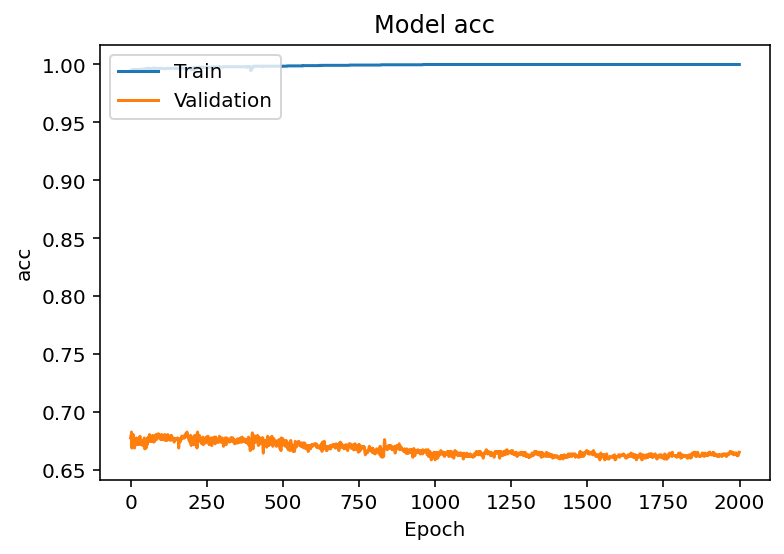

In [79]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'Epoch')

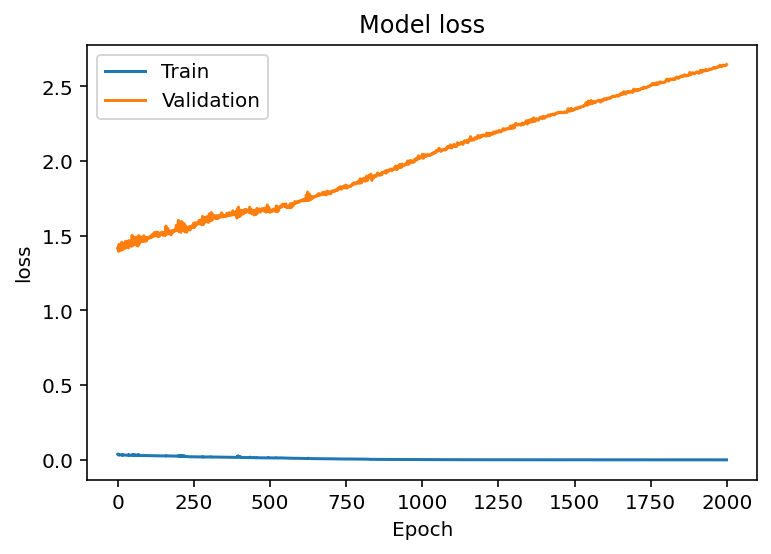

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [73]:
pred = lstm.predict(X_test)

In [74]:
pred[pred>0.5]=1
pred[pred<=0.5]=0

In [75]:
pred.sum()

1534.0

In [76]:
y_test.sum()

1098

In [77]:
from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, pred))

정확도 : 0.5972161809482384


In [58]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'])

# Fitting the RNN to the Training set
# history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=100)#,  callbacks=[early_stop])

Epoch 1/100
33/33 [==============================] - 5s 52ms/step - loss: 2.2420 - acc: 0.4682 - val_loss: 0.6903 - val_acc: 0.6196
Epoch 2/100
33/33 [==============================] - 1s 28ms/step - loss: 0.5366 - acc: 0.7390 - val_loss: 0.6654 - val_acc: 0.6255
Epoch 3/100
33/33 [==============================] - 1s 28ms/step - loss: 0.5204 - acc: 0.7545 - val_loss: 0.6619 - val_acc: 0.6647
Epoch 4/100
33/33 [==============================] - 1s 28ms/step - loss: 0.5036 - acc: 0.7528 - val_loss: 0.6633 - val_acc: 0.6880
Epoch 5/100
33/33 [==============================] - 1s 28ms/step - loss: 0.4896 - acc: 0.7746 - val_loss: 1.0533 - val_acc: 0.6764
Epoch 6/100
33/33 [==============================] - 1s 28ms/step - loss: 0.4800 - acc: 0.7646 - val_loss: 1.1242 - val_acc: 0.6742
Epoch 7/100
33/33 [==============================] - 1s 27ms/step - loss: 0.5518 - acc: 0.7790 - val_loss: 1.4480 - val_acc: 0.6480
Epoch 8/100
33/33 [==============================] - 1s 28ms/step - loss: 0.

33/33 [==============================] - 1s 28ms/step - loss: 0.0862 - acc: 0.9697 - val_loss: 3.1767 - val_acc: 0.6785
Epoch 63/100
33/33 [==============================] - 1s 29ms/step - loss: 0.1144 - acc: 0.9631 - val_loss: 3.1194 - val_acc: 0.6705
Epoch 64/100
33/33 [==============================] - 1s 28ms/step - loss: 0.1150 - acc: 0.9646 - val_loss: 3.0517 - val_acc: 0.6749
Epoch 65/100
33/33 [==============================] - 1s 28ms/step - loss: 0.1969 - acc: 0.9498 - val_loss: 3.1205 - val_acc: 0.6611
Epoch 66/100
33/33 [==============================] - 1s 29ms/step - loss: 0.2899 - acc: 0.9288 - val_loss: 2.3006 - val_acc: 0.6858
Epoch 67/100
33/33 [==============================] - 1s 29ms/step - loss: 0.1137 - acc: 0.9663 - val_loss: 2.9663 - val_acc: 0.6771
Epoch 68/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0825 - acc: 0.9794 - val_loss: 3.2405 - val_acc: 0.6742
Epoch 69/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0894 

Text(0.5, 1.0, 'Model acc')

Text(0, 0.5, 'acc')

Text(0.5, 0, 'Epoch')

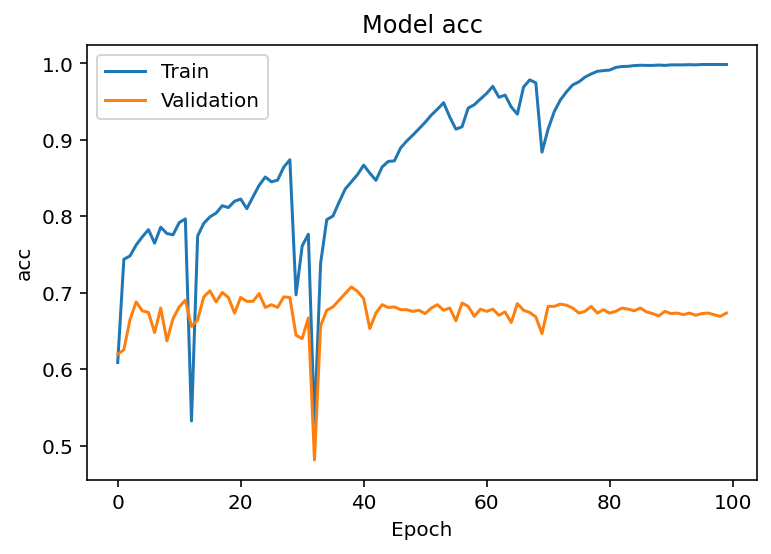

In [59]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'Epoch')

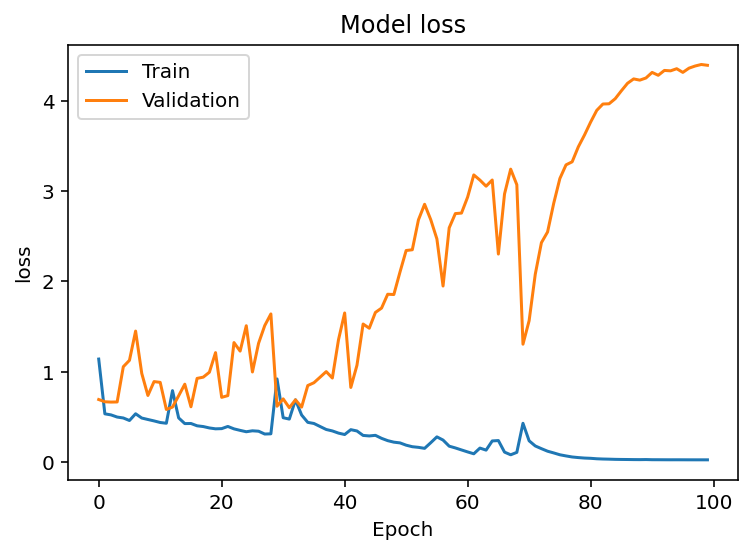

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [61]:
model = Sequential()
model.add(LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               316400    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 322,996
Trainable params: 322,996
Non-trainable params: 0
_________________________________________________________________


In [62]:
for i in range(1,10000):
    if 7799%i == 0:
        print(i)

1
11
709
7799


In [63]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics=['acc'])
history = model.fit(X_train, y_train, validation_split=0.25, batch_size=709, epochs=100, shuffle=False)#,  callbacks=[early_stop])

Epoch 1/100
6/6 [==============================] - 2s 109ms/step - loss: 0.6607 - acc: 0.5670 - val_loss: 0.6557 - val_acc: 0.5782
Epoch 2/100
6/6 [==============================] - 0s 49ms/step - loss: 0.5629 - acc: 0.6977 - val_loss: 0.6460 - val_acc: 0.5789
Epoch 3/100
6/6 [==============================] - 0s 48ms/step - loss: 0.5357 - acc: 0.6989 - val_loss: 0.6210 - val_acc: 0.6145
Epoch 4/100
6/6 [==============================] - 0s 48ms/step - loss: 0.5193 - acc: 0.7326 - val_loss: 0.6137 - val_acc: 0.6705
Epoch 5/100
6/6 [==============================] - 0s 49ms/step - loss: 0.5016 - acc: 0.7602 - val_loss: 0.6051 - val_acc: 0.6858
Epoch 6/100
6/6 [==============================] - 0s 49ms/step - loss: 0.4876 - acc: 0.7747 - val_loss: 0.5981 - val_acc: 0.7018
Epoch 7/100
6/6 [==============================] - 0s 50ms/step - loss: 0.4751 - acc: 0.7806 - val_loss: 0.5904 - val_acc: 0.7127
Epoch 8/100
6/6 [==============================] - 0s 48ms/step - loss: 0.4631 - acc: 0.7

6/6 [==============================] - 0s 51ms/step - loss: 0.2300 - acc: 0.8967 - val_loss: 0.9034 - val_acc: 0.6633
Epoch 64/100
6/6 [==============================] - 0s 50ms/step - loss: 0.2047 - acc: 0.9164 - val_loss: 1.1995 - val_acc: 0.6960
Epoch 65/100
6/6 [==============================] - 0s 49ms/step - loss: 0.1405 - acc: 0.9377 - val_loss: 1.4417 - val_acc: 0.6902
Epoch 66/100
6/6 [==============================] - 0s 49ms/step - loss: 0.3660 - acc: 0.8733 - val_loss: 1.0546 - val_acc: 0.6662
Epoch 67/100
6/6 [==============================] - 0s 50ms/step - loss: 0.1992 - acc: 0.9125 - val_loss: 1.2224 - val_acc: 0.6996
Epoch 68/100
6/6 [==============================] - 0s 50ms/step - loss: 0.1389 - acc: 0.9430 - val_loss: 1.2894 - val_acc: 0.6975
Epoch 69/100
6/6 [==============================] - 0s 49ms/step - loss: 0.1398 - acc: 0.9393 - val_loss: 0.9732 - val_acc: 0.6371
Epoch 70/100
6/6 [==============================] - 0s 50ms/step - loss: 0.1888 - acc: 0.9064 - 

Text(0.5, 1.0, 'Model acc')

Text(0, 0.5, 'acc')

Text(0.5, 0, 'Epoch')

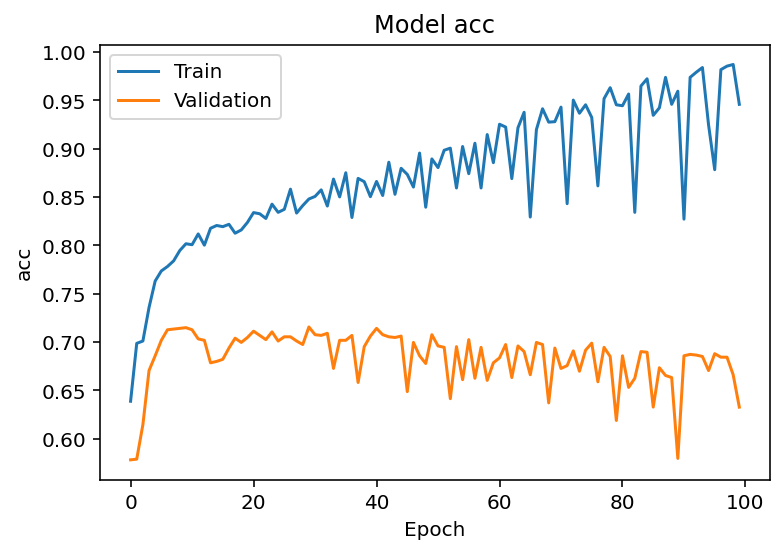

In [64]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'Epoch')

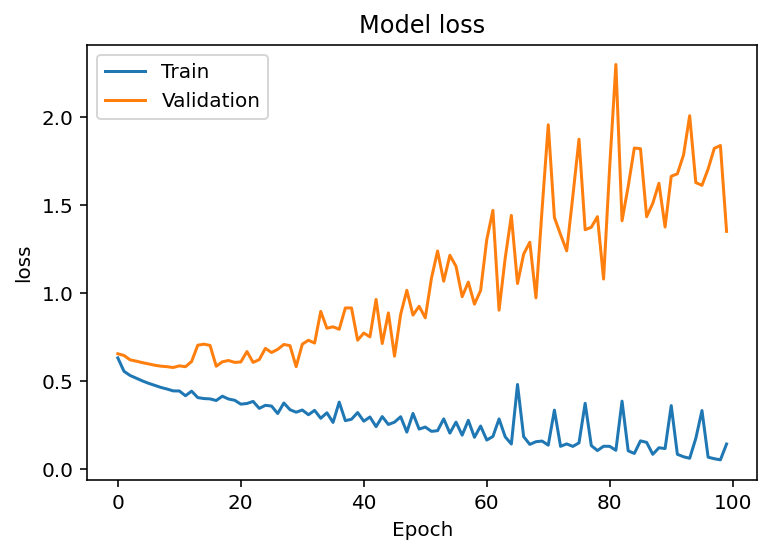

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [66]:
model = Sequential()
model.add(LSTM(12, input_shape = (X_train.shape[1], X_train.shape[2])))
# model.add(Dense(6))
# model.add(Dropout(0.9))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 12)                33744     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 13        
Total params: 33,757
Trainable params: 33,757
Non-trainable params: 0
_________________________________________________________________


In [67]:
model = Sequential()
model.add(LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               316400    
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 322,996
Trainable params: 322,996
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min',patience=20)
history = model.fit(X_train, y_train, epochs=12, batch_size=790, validation_split=0.1, shuffle=False)#,  callbacks=[es])

Epoch 1/12
7/7 [==============================] - 2s 93ms/step - loss: 0.6619 - acc: 0.5721 - val_loss: 0.7088 - val_acc: 0.5073
Epoch 2/12
7/7 [==============================] - 0s 44ms/step - loss: 0.5646 - acc: 0.6926 - val_loss: 0.6954 - val_acc: 0.5073
Epoch 3/12
7/7 [==============================] - 0s 44ms/step - loss: 0.5380 - acc: 0.6934 - val_loss: 0.6860 - val_acc: 0.5455
Epoch 4/12
7/7 [==============================] - 0s 43ms/step - loss: 0.5149 - acc: 0.7407 - val_loss: 0.6994 - val_acc: 0.5818
Epoch 5/12
7/7 [==============================] - 0s 43ms/step - loss: 0.5006 - acc: 0.7582 - val_loss: 0.7045 - val_acc: 0.6036
Epoch 6/12
7/7 [==============================] - 0s 43ms/step - loss: 0.4892 - acc: 0.7635 - val_loss: 0.7108 - val_acc: 0.6200
Epoch 7/12
7/7 [==============================] - 0s 44ms/step - loss: 0.4793 - acc: 0.7734 - val_loss: 0.7000 - val_acc: 0.6382
Epoch 8/12
7/7 [==============================] - 0s 44ms/step - loss: 0.4693 - acc: 0.7798 - val

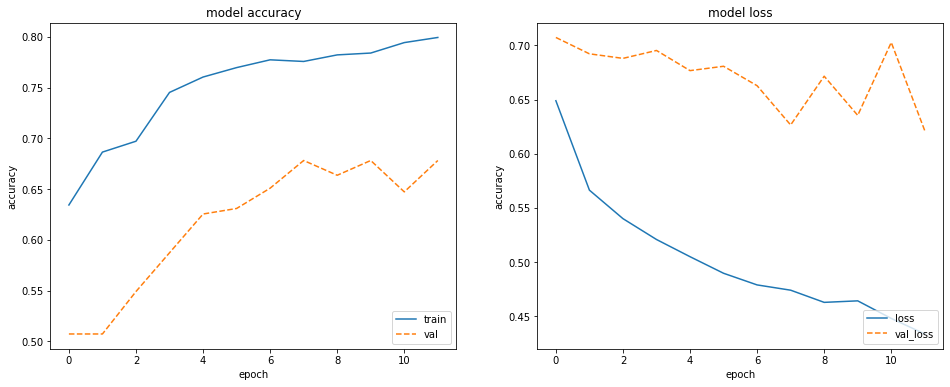

In [286]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['loss', 'val_loss'], loc='lower right')

In [287]:
pred = lstm.predict(X_test)
pred[pred>0.5]=1
pred[pred<=0.5]=0

In [289]:
print(pred.sum())
print(y_test.sum())
print(pred.shape)
from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, pred))

1641.0
1098
(2299, 1)
정확도 : 0.622879512831666


# 틀린 환자 확인

In [293]:
pred1 = pd.DataFrame(pred)
y_test1 = pd.DataFrame(y_test)

In [302]:
pred1.iloc[0]==y_test1.iloc[0]

0    True
Name: 0, dtype: bool

In [313]:
a = pred1-y_test1
a[a[0]==1].index

Int64Index([   1,    2,    4,    5,   12,   13,   18,   22,   24,   28,
            ...
            2267, 2271, 2273, 2274, 2275, 2278, 2286, 2287, 2288, 2294],
           dtype='int64', length=705)

In [320]:
X_test[1,:,:].sum(axis=1)

array([36., 30., 27.,  0.,  0., 18., 27.,  0.,  0.,  2.])

In [321]:
X_test[3,:,:].sum(axis=1)

array([ 3., 18., 14.,  0.,  6., 19., 38.,  0.,  0.,  0.])